In [1]:
from google.colab import drive

drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


## Custom Unet

In [2]:
""" Parts of the U-Net model """

import torch
import torch.nn as nn
import torch.nn.functional as F


class DoubleConv(nn.Module):
    """(convolution => [BN] => ReLU) * 2"""

    def __init__(self, in_channels, out_channels, mid_channels=None):
        super().__init__()
        if not mid_channels:
            mid_channels = out_channels
        self.double_conv = nn.Sequential(
            nn.Conv2d(in_channels, mid_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(mid_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(mid_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        return self.double_conv(x)


class Down(nn.Module):
    """Downscaling with maxpool then double conv"""

    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.maxpool_conv = nn.Sequential(
            nn.MaxPool2d(2),
            DoubleConv(in_channels, out_channels)
        )

    def forward(self, x):
        return self.maxpool_conv(x)


class Up(nn.Module):
    """Upscaling then double conv"""

    def __init__(self, in_channels, out_channels):
        super().__init__()

        self.up = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)
        self.conv = DoubleConv(in_channels, out_channels, in_channels // 2)


    def forward(self, x):
        out = self.up(x)
        return self.conv(out)


class OutConv(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(OutConv, self).__init__()
        self.conv = nn.Conv2d(in_channels, out_channels, kernel_size=1)

    def forward(self, x):
        return self.conv(x)

""" Full assembly of the parts to form the complete network """

import torch.nn.functional as F


class UNet(nn.Module):
    def __init__(self):
        super(UNet, self).__init__()
        self.n_channels = 1
        self.n_classes = 1


        self.inc = DoubleConv(self.n_channels, 16)
        self.down1 = Down(16, 32)
        self.down2 = Down(32, 64)
        self.down3 = Down(64, 128)
        self.down4 = Down(128, 256)
        self.down5 = Down(256, 512)


        self.up1 = Up(512, 256)
        self.up2 = Up(256, 128)
        self.up3 = Up(128, 64)
        self.up4 = Up(64, 32)
        self.up5 = Up(32, 16)
        self.outc = OutConv(16, self.n_classes)

    def forward(self, x):
        out = self.inc(x)
        out = self.down1(out)
        out = self.down2(out)
        out = self.down3(out)
        out = self.down4(out)
        out = self.down5(out)

        out = self.up1(out)
        out = self.up2(out)
        out = self.up3(out)
        out = self.up4(out)
        out = self.up5(out)
        logits = self.outc(out)
        return logits

ae = UNet()

In [3]:
import torch

x_data = torch.load("gdrive/MyDrive/preprocessed_images_with_metadata_and_target.pt.nosync")

In [4]:
def flip_image(image):
  left_side_count = np.count_nonzero(image[:, :image.shape[1] // 2])
  right_side_count = np.count_nonzero(image[:, image.shape[1] // 2:])

  if left_side_count < right_side_count:
      flipped_image = np.fliplr(image)
  else:
      flipped_image = image
  return flipped_image

In [5]:
import numpy as np

images = np.array([flip_image(d[1].numpy()) for d in x_data]).reshape((-1, 1, 512, 512))
del x_data
images_new = torch.tensor(images)
del images
images = images_new
images.shape

torch.Size([2304, 1, 512, 512])

In [6]:
import gc
gc.collect()

9

In [7]:
from torch.utils.data import TensorDataset, DataLoader
from sklearn.model_selection import train_test_split


X1_train, X1_val = train_test_split(images, test_size=0.15, random_state=3451)
del images

In [8]:
from torchvision import transforms
from torch.utils.data import Dataset

data_transforms = transforms.Compose([
    transforms.RandomAffine(degrees=10, scale=(0.8, 1.2)),
])

class AugumentationDataset(Dataset):

    def __init__(self, data, transform):
        self.data = data
        self.transform = transform

    def __len__(self):
        return self.data.shape[0]

    def __getitem__(self, idx):
        item = self.data[idx]
        item = self.transform(item)
        return item

X1_dataset = AugumentationDataset(X1_train, data_transforms)


train_dataloader = DataLoader(X1_dataset, batch_size=8, shuffle=True)

val_dataloader = DataLoader(X1_val, batch_size=8)
del X1_train, X1_val
gc.collect()

0

In [9]:
import torch
torch.cuda.empty_cache()

import gc
gc.collect()

0

In [10]:
!nvidia-smi

Sun Nov  5 17:12:43 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.105.17   Driver Version: 525.105.17   CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   60C    P8    10W /  70W |      0MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [11]:
ae

UNet(
  (inc): DoubleConv(
    (double_conv): Sequential(
      (0): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
      (3): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (4): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (5): ReLU(inplace=True)
    )
  )
  (down1): Down(
    (maxpool_conv): Sequential(
      (0): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (1): DoubleConv(
        (double_conv): Sequential(
          (0): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): ReLU(inplace=True)
          (3): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (4): BatchNorm2d(32, eps=1e-05, momentum=0.

In [12]:
ae = UNet().to('cuda')
with torch.no_grad():
  output = ae(next(iter(train_dataloader)).float().to('cuda'))
  print(output.shape)

torch.Size([8, 1, 512, 512])


In [13]:
from matplotlib import pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim

ae = UNet().to('cuda')

criterion = nn.MSELoss()

optimizer = optim.Adam(ae.parameters(), lr=0.001)

num_epochs = 100
train_losses = []
val_losses = []
best_val_score = float('inf')

for epoch in range(num_epochs):
    ae.train()
    running_train_loss = 0.0

    for i, data in enumerate(train_dataloader, 0):
        batched_images = data  # Assuming you're using unlabeled data
        batched_images = (batched_images.to('cuda') * 255).float()

        optimizer.zero_grad()

        outputs = ae(batched_images)
        loss = criterion(outputs.float(), batched_images)  # Compute reconstruction loss

        loss.backward()
        optimizer.step()

        running_train_loss += loss.item()

    train_loss = running_train_loss / (i + 1)
    train_losses.append(train_loss)

    ae.eval()  # Set the autoencoder to evaluation mode
    val_loss = 0.0

    with torch.no_grad():
        for i, data in enumerate(val_dataloader, 0):
            batched_images = data  # Assuming you're using unlabeled data
            batched_images = (batched_images.to('cuda') * 255).float()

            outputs = ae(batched_images)
            loss = criterion(outputs.float(), batched_images)  # Compute reconstruction loss

            val_loss += loss.item()

    val_loss = val_loss / (i + 1)
    val_losses.append(val_loss)

    print(f'Epoch {epoch + 1}, Validation Loss: {round(val_loss, 3)}, Training Loss: {round(train_loss, 3)}')
    print(val_loss < best_val_score, val_loss, best_val_score)
    if val_loss < best_val_score:
      best_val_score = val_loss
      print(f"Saving model, new loss - {best_val_score}")
      torch.save(ae.state_dict(), 'gdrive/MyDrive/autoencoder_v2.pth')

# Visualize the loss
plt.plot(train_losses, label='Training Loss', color='blue')
plt.plot(val_losses, label='Validation Loss', color='red')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Training and Validation Loss')
plt.show()


Epoch 1, Validation Loss: 4105.331, Training Loss: 3617.132
True 4105.3312877308235 inf
Saving model, new loss - 4105.3312877308235
Epoch 2, Validation Loss: 3003.882, Training Loss: 3142.711
True 3003.881738836115 4105.3312877308235
Saving model, new loss - 3003.881738836115
Epoch 3, Validation Loss: 2594.04, Training Loss: 2487.202
True 2594.0396118164062 3003.881738836115
Saving model, new loss - 2594.0396118164062
Epoch 4, Validation Loss: 1211.098, Training Loss: 1690.55
True 1211.0978171608665 2594.0396118164062
Saving model, new loss - 1211.0978171608665
Epoch 5, Validation Loss: 1014.245, Training Loss: 1037.205
True 1014.2447232333096 1211.0978171608665
Saving model, new loss - 1014.2447232333096
Epoch 6, Validation Loss: 246.619, Training Loss: 621.992
True 246.61905566128817 1014.2447232333096
Saving model, new loss - 246.61905566128817
Epoch 7, Validation Loss: 343.721, Training Loss: 394.889
False 343.720854325728 246.61905566128817
Epoch 8, Validation Loss: 308.897, Train

KeyboardInterrupt: ignored

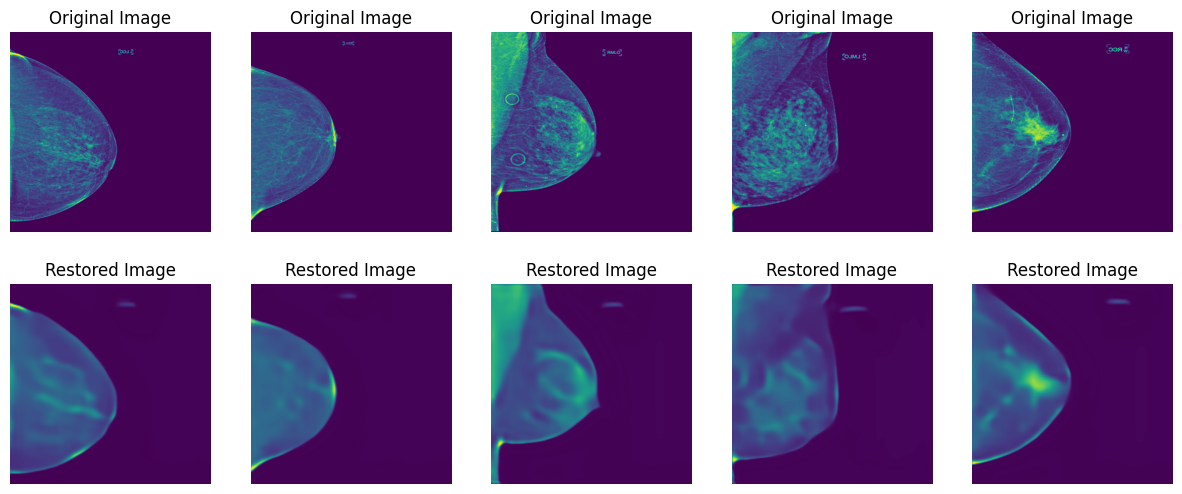

In [14]:
def visualize_images(original, restored, num_pairs=5):
    fig, axes = plt.subplots(2, num_pairs, figsize=(15, 6))

    for i in range(num_pairs):
        axes[0, i].set_title("Original Image")
        axes[0, i].axis('off')
        axes[0, i].imshow(original[i].permute(1, 2, 0).cpu())

        axes[1, i].set_title("Restored Image")
        axes[1, i].axis('off')
        axes[1, i].imshow(restored[i].permute(1, 2, 0).cpu())

    plt.show()


num_image_pairs_to_visualize = 5
with torch.no_grad():
    inputs = next(iter(val_dataloader))
    outputs = ae(inputs[: num_image_pairs_to_visualize].to('cuda').float())
    restored_images = outputs

visualize_images(inputs, restored_images, num_pairs=num_image_pairs_to_visualize)